In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle

%matplotlib inline

In [2]:
# import tensorflow as tf
# tf.test.gpu_device_name()

In [3]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [4]:
# !nvidia-smi

In [5]:
# To display all columns:
pd.pandas.set_option('display.max_columns', None)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# os.chdir(r'/content/drive/MyDrive/higgs boson/')

## Loding Data:

In [8]:
# For colab
# df1 = pd.read_csv('train_MICE_median_ind_QuantileTransformer.csv')
# df2 = pd.read_csv('train_MICE_med_ind_QT_dropOutlier.csv')

df1 = pd.read_csv('../data/interim/train_MICE_median_ind_QuantileTransformer.csv')
df2 = pd.read_csv('../data/interim/train_MICE_med_ind_QT_dropOutlier.csv')

In [9]:
X, y = df1.drop(columns=['Weight', 'Label']), df1['Weight']
X2, y2 = df2.drop(columns=['Weight', 'Label']), df2['Weight']

In [10]:
print(df1.shape, df2.shape, sep='\n')

(250000, 33)
(236794, 33)


## Train-test split:

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30000)     # about 12%
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=30000)   # about 12%

## Visualizing Weight column:

<AxesSubplot:xlabel='Weight', ylabel='Count'>

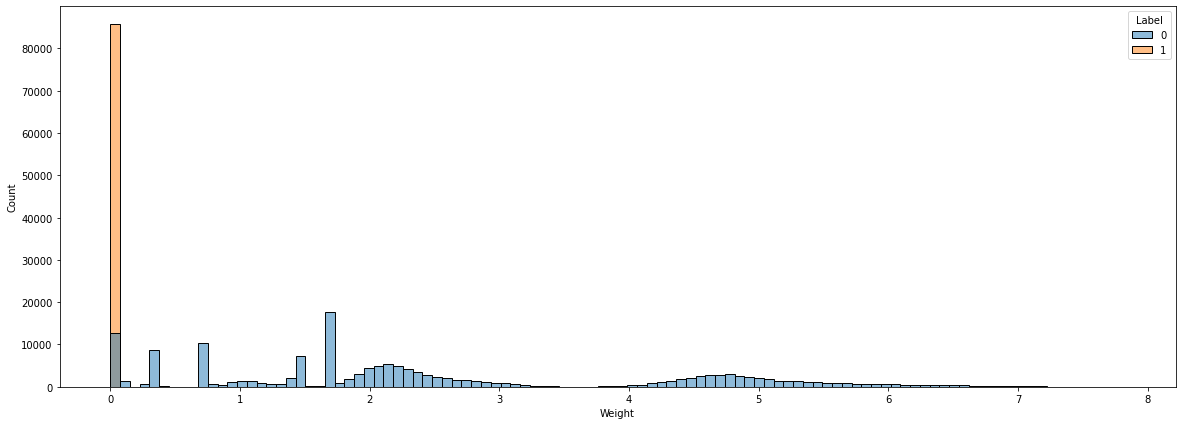

In [12]:
plt.figure(figsize=(20, 7))
sns.histplot(data=df1, x='Weight', hue='Label')

<AxesSubplot:xlabel='Weight', ylabel='Count'>

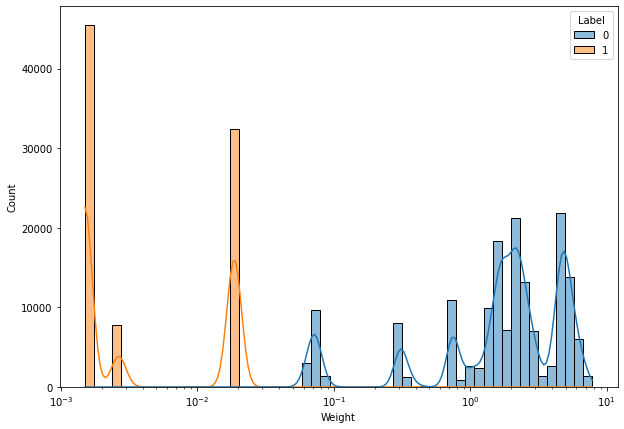

In [13]:
plt.figure(figsize=(10, 7))
sns.histplot(data=df1, x='Weight', hue='Label', log_scale=True, kde=True)

## Grid Search CV:

In [14]:
# import pickle
# # Write the object to file
# with open('grid_search_info.pkl', 'wb') as f:
#     pickle.dump((t1, t2), f)

<b style="color: orange; font-size: 20px;"> Note:</b><br /> <p>Grid Search CV is turning out to be too computationally expensive. So going with `cross_val_score()` & manually saving the models.</p>

## Lazy Predict:

The below block of code almost took `8 hrs` in my local machine. Hopefully never doing it again!!!

In [15]:
# Import libraries
from lazypredict.Supervised import LazyRegressor

# Defines and builds the lazyclassifier
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

f:\installationfolder\anaconda\envs\higgs_boson\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Prints the model performance
models

 26%|█████████████████████▍                                                            | 11/42 [07:59<23:34, 45.64s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 361. GiB for an array with shape (220000, 220000) and data type float64


 40%|█████████████████████████████████▏                                                | 17/42 [18:01<39:01, 93.67s/it]

KernelRidge model failed to execute
Unable to allocate 361. GiB for an array with shape (220000, 220000) and data type float64


100%|█████████████████████████████████████████████████████████████████████████████| 42/42 [14:31:21<00:00, 1244.81s/it]


NameError: name 'models_train' is not defined

In [23]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.63,0.63,1.15,9.21
LGBMRegressor,0.63,0.63,1.15,4.15
MLPRegressor,0.62,0.62,1.15,242.95
XGBRegressor,0.62,0.62,1.15,55.54
ExtraTreesRegressor,0.62,0.62,1.15,282.19
RandomForestRegressor,0.62,0.62,1.16,1444.73
NuSVR,0.61,0.61,1.17,29308.84
GradientBoostingRegressor,0.60,0.60,1.18,266.84
SVR,0.60,0.60,1.18,20098.85


In [24]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.63,0.63,1.15,9.21
LGBMRegressor,0.63,0.63,1.15,4.15
MLPRegressor,0.62,0.62,1.15,242.95
XGBRegressor,0.62,0.62,1.15,55.54
ExtraTreesRegressor,0.62,0.62,1.15,282.19
RandomForestRegressor,0.62,0.62,1.16,1444.73
NuSVR,0.61,0.61,1.17,29308.84
GradientBoostingRegressor,0.60,0.60,1.18,266.84
SVR,0.60,0.60,1.18,20098.85


In [41]:
try:
    os.mkdir(r'../reports/lazypredict')
    os.mkdir(r'../reports/lazypredict/regg')
except FileExistsError as fee:
    print(fee)

[WinError 183] Cannot create a file when that file already exists: '../reports/lazypredict'


In [18]:
import sklearn
ver = 'sklearn==' + str(sklearn.__version__) + '\nlazypredict==0.2.9'
ver

'sklearn==0.23.1\nlazypredict==0.2.9'

In [19]:
with open('../reports/lazypredict/regg/dependency.txt', 'w') as fp:
    fp.write(ver)

In [25]:
sub = str(time.localtime().tm_hour) + '_' + str(time.localtime().tm_min) \
    + '_' + str(time.localtime().tm_mday) + '_' + str(time.localtime().tm_mon) \
    + '_' + str(time.localtime().tm_year)
sub

'2_12_10_9_2021'

In [29]:
# Saving LazyPredict csv files & model for future refernce
models.to_csv(f"../reports/lazypredict/regg/train_{sub}.csv", index=False)
predictions.to_csv(f"../reports/lazypredict/regg/predict_{sub}.csv", index=False)


# Saving lazypredict model
# The saved file is 3.57 GB & must be added in gitignore
with open(f'../reports/lazypredict/regg/Lazypredict_regg_model_{sub}.pkl', 'wb') as fptr:
    pickle.dump(reg, fptr)
    print('Model saved in reports folder...')
    
# Saving also in models folder:
with open(f'../models/regg/Lazypredict_regg_model_{sub}.pkl', 'wb') as fptr:
    pickle.dump(reg, fptr)
    print('Model saved in models folder...')

Model saved in reports folder...
Model saved in models folder...


## Cross Val Score:

In [24]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb

### Metrics:

In [16]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### SVR:

Use sorted(sklearn.metrics.SCORERS.keys()) to get valid scoring options.

In [20]:
dirPath = '../models/regg'
if not os.path.isdir(dirPath):
    os.mkdir(dirPath)

dirPath = '../models/regg/outlier_present'
if not os.path.isdir(dirPath):
    os.mkdir(dirPath)
    
def model_eval_and_save(model, save_path, cv=5, scoring='r2'): 
    
    
    ## Model 1
    start_time = time.time()   #returns in seconds
    scores = cross_val_score(model, X=X_train, y=y_train, cv=cv, n_jobs=4, scoring=scoring, verbose=1)
    stop_time = time.time()
    
    print('No outliers:')
    print('Time Taken = ',stop_time-start_time, '\nCross-Val scores', scores, '\n Mean =', scores.mean())
    save_path = save_path + str(abs(round(scores.mean() * 100))) + '.pkl'
    path = os.path.join('../models/regg', save_path)
    
    with open(path, 'wb') as f:
        pickle.dump((model, scores), f)
        
    
    ## Model 2
    start_time = time.time()   #returns in seconds
    scores = cross_val_score(model, X=X_train2, y=y_train2, cv=cv, n_jobs=4, scoring=scoring, verbose=1)
    stop_time = time.time()
    
    print('\n\nWith outliers:')
    print('Time Taken = ',stop_time-start_time, '\nCross-Val scores', scores, '\n Mean =', scores.mean())
    save_path = save_path + str(abs(round(scores.mean() * 100))) + '.pkl'
    path = os.path.join('../models/regg/outlier_present', save_path)
    
    with open(path, 'wb') as f:
        pickle.dump((model, scores), f)

In [21]:
svr_regg = SVR(kernel='rbf', gamma='scale', C=1, max_iter=5000, cache_size=2048, verbose=True)
model_eval_and_save(svr_regg, 'svr_rbf_C1_gamm_scale_')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 12.2min finished


No outliers:
Time Taken =  733.955518245697 
Cross-Val scores [0.13868801 0.15352692 0.16746265 0.07005819 0.14554902] 
 Mean = 0.13505695605045967


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 13.6min finished




With outliers:
Time Taken =  819.3875195980072 
Cross-Val scores [ 0.11570777  0.1288641  -0.01794811  0.09418688  0.09094798] 
 Mean = 0.08235172418421069


In [22]:
svr_regg.get_params()

{'C': 1,
 'cache_size': 2048,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 5000,
 'shrinking': True,
 'tol': 0.001,
 'verbose': True}

In [23]:
svr_regg = SVR(kernel='rbf', C=1, gamma=0.01, max_iter=5000, cache_size=2048, verbose=True)
model_eval_and_save(svr_regg, 'svr_rbf_C1_gamma_0.01_')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 13.8min finished


No outliers:
Time Taken =  826.846408367157 
Cross-Val scores [-0.03084286  0.00892738  0.15900785 -0.03585802  0.13097372] 
 Mean = 0.046441612353400184


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 13.0min finished




With outliers:
Time Taken =  783.3531200885773 
Cross-Val scores [ 0.14967399 -0.36038079 -0.25764948  0.0980446   0.06140217] 
 Mean = -0.06178190355074169


In [25]:
svr_regg = SVR(kernel='rbf', C=1, gamma=0.1, max_iter=5000, cache_size=2048, verbose=True)
model_eval_and_save(svr_regg, 'svr_rbf_C1_gamma_0.1_')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 21.8min finished


No outliers:
Time Taken =  1308.8693397045135 
Cross-Val scores [-0.11281205 -0.16048036 -0.17183194 -0.14068904 -0.17968873] 
 Mean = -0.1531004222273557


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 16.5min finished




With outliers:
Time Taken =  991.2918491363525 
Cross-Val scores [-0.07394985 -0.10213282 -0.17384107 -0.12228898 -0.17207099] 
 Mean = -0.1288567436793226


In [26]:
svr_regg = SVR(kernel='rbf', C=1, gamma=0.5, max_iter=5000, cache_size=2048, verbose=True)
model_eval_and_save(svr_regg, 'svr_rbf_C1_gamma_0.5_')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 21.2min finished


No outliers:
Time Taken =  1273.5208246707916 
Cross-Val scores [-0.2522309  -0.27800775 -0.29233762 -0.2589225  -0.26843484] 
 Mean = -0.26998672303366733


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 16.6min finished




With outliers:
Time Taken =  998.6097266674042 
Cross-Val scores [-0.23229521 -0.23860519 -0.23040999 -0.23329007 -0.25685807] 
 Mean = -0.23829170711106112


In [27]:
svr_regg = SVR(kernel='rbf', C=1, gamma=1, max_iter=5000, cache_size=2048, verbose=True)
model_eval_and_save(svr_regg, 'svr_rbf_C1_gamma_1_')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 16.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


No outliers:
Time Taken =  990.5140190124512 
Cross-Val scores [-0.35440475 -0.37695757 -0.36823149 -0.38489784 -0.37218779] 
 Mean = -0.37133588878247503


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 14.9min finished




With outliers:
Time Taken =  896.5695567131042 
Cross-Val scores [-0.32909969 -0.3336164  -0.33227034 -0.34422327 -0.33718871] 
 Mean = -0.3352796826519828


In [27]:
svr_regg = SVR(C=0.6, max_iter=5000, cache_size=2048, verbose=True)
model_eval_and_save(svr_regg, 'svr_rbf_C0.6_')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 12.3min finished


No outliers:
Time Taken =  739.4297578334808 
Cross-Val scores [0.18677919 0.11618343 0.13136201 0.10135648 0.14492388] 
 Mean = 0.13612099903813202


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.




With outliers:
Time Taken =  598.8150811195374 
Cross-Val scores [0.13968623 0.1963882  0.20289537 0.18391555 0.18343414] 
 Mean = 0.18126389792541128


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 10.0min finished


## Model creation function:

In [22]:
from sklearn.metrics import r2_score, mean_squared_error

def grid_search_model(params, model, num=1):
    gs = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs = -1)
    if num ==1:
        gs.fit(X_train, y_train)
        
        train_pred = gs.predict(X_train)
        mse_train = mean_squared_error(y_train, train_pred)
        
        pred = gs.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        rsq = r2_score (y_test, pred)
    else:
        gs.fit(X_train2, y_train2)
        
        train_pred = gs.predict(X_train2)
        mse_train = mean_squared_error(y_train2, train_pred)
        
        pred = gs.predict(X_test2)
        mse = mean_squared_error(y_test2, pred)
        rsq = r2_score (y_test2, pred)
    
    df4 = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
#     df4.head()

    print(gs.best_params_)
    print("Mse train - ", mse_train)
    print("r2 = ", gs.best_score_)
    print('\n\nTest score:\nMSE = {}\nr2 = {}'.format(mse, rsq))
    return gs, df4

### Decision Tree:

In [30]:
params = {
    'max_depth': np.arange(9, 12),
    'min_samples_split': [150, 200, 280],
    'max_features': [0.9],
    'min_samples_leaf': [100]
}

dt = DecisionTreeRegressor(criterion='friedman_mse')
dt_model1, df_dt_model1 = grid_search_model(params, dt)

{'max_depth': 11, 'max_features': 0.9, 'min_samples_leaf': 100, 'min_samples_split': 280}
0.5933631840345367
Mse train -  1.337113509165814


 Test score:
MSE = 1.4268537109619273
r2 = 0.5953758331383692


In [33]:
# Outliers Removed Dataset
dt_model12, df_dt_model12 = grid_search_model(params, dt, 2)

{'max_depth': 11, 'max_features': 0.9, 'min_samples_leaf': 100, 'min_samples_split': 150}
Mse train -  1.334840888908467
r2 =  0.5893100154923031


 Test score:
MSE = 1.4310039546710132
r2 = 0.5918964740101245


In [25]:
params = {
    'max_depth': np.arange(12, 15),
    'min_samples_split': [150, 200],
    'max_features': [1, 0.9],
    'min_samples_leaf': [50, 100]
}

dt = DecisionTreeRegressor(criterion='mse')
dt_model2, df_dt_model2 = grid_search_model(params, dt)

{'max_depth': 13, 'max_features': 0.9, 'min_samples_leaf': 100, 'min_samples_split': 150}
Mse train -  1.2968459862649004
r2 =  0.5945083725344185


Test score:
MSE = 1.4281820299959822
r2 = 0.59215809094894


In [28]:
# Outliers Removed Dataset
params = {
    'max_depth': np.arange(13, 15),
    'min_samples_split': [150, 200],
    'max_features': [1, 0.9],
    'min_samples_leaf': [50, 100]
}

dt = DecisionTreeRegressor(criterion='mse')
dt_model2, df_dt_model2 = grid_search_model(params, dt, 2)

{'max_depth': 14, 'max_features': 0.9, 'min_samples_leaf': 100, 'min_samples_split': 200}
Mse train -  1.298312486865659
r2 =  0.5912876411466558


Test score:
MSE = 1.43892122092642
r2 = 0.5905166034349092


In [26]:
params = {
    'max_depth': np.arange(13, 16),
    'min_samples_split': [150, 180],
    'max_features': [0.9, 0.85],
    'min_samples_leaf': [100]
}

dt = DecisionTreeRegressor(criterion='mse')
dt_model2, df_dt_model2 = grid_search_model(params, dt)

{'max_depth': 14, 'max_features': 0.9, 'min_samples_leaf': 100, 'min_samples_split': 180}
Mse train -  1.2904416263378717
r2 =  0.5944908741276382


Test score:
MSE = 1.4334141882707552
r2 = 0.5906639582862803


In [27]:
# Outliers Removed Dataset
params = {
    'max_depth': np.arange(13, 16),
    'min_samples_split': [150, 180],
    'max_features': [0.9, 0.85],
    'min_samples_leaf': [100]
}

dt = DecisionTreeRegressor(criterion='mse')
dt_model2, df_dt_model2 = grid_search_model(params, dt, 2)

{'max_depth': 13, 'max_features': 0.85, 'min_samples_leaf': 100, 'min_samples_split': 150}
Mse train -  1.3034873755853376
r2 =  0.5908531928052436


Test score:
MSE = 1.435925006398814
r2 = 0.5913692561609646


## Random Forest:

In [ ]:
{'bootstrap': True, 'max_depth': 7, 'max_features': 0.9, 'max_samples': 0.9, 'min_samples_leaf': 80, 'min_samples_split': 200, 'oob_score': True, 'warm_start': False}
Mse train -  1.4064382655802377
r2 =  0.5938314425643212


Test score:
MSE = 1.4416070165563246
r2 = 0.5911921218449644

In [ ]:
params = {
    'n_estimators': [200],
    'max_depth': [7, 8, 9],
    'max_features': [0.9, 0.8],
    'bootstrap': [True],
    'max_samples': [0.9, 0.8],
    'warm_start': [False],
    'min_samples_split': [150],
    'min_samples_leaf': [80],
    'oob_score': [True],
}
rf1 = RandomForestRegressor(criterion='mse')
rf_model1, df_rf_model1 = grid_search_model(params, rf1)

In [ ]:
df_rf_model1

In [ ]:
params = {
    'n_estimators': [200],
    'max_depth': [7, 8, 9],
    'max_features': [1],
    'bootstrap': [True],
    'max_samples': [1],
    'warm_start': [False],
    'min_samples_split': [150],
    'min_samples_leaf': [80],
    'oob_score': [True],
}
rf2 = RandomForestRegressor(criterion='mse')
rf_model2, df_rf_model2 = grid_search_model(params, rf1, 2)

In [ ]:
df_rf_model2.head()

In [ ]:
# For changing styling:
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("styles/custom.css", "r").read()
#     return HTML(styles)
# css_styling()